# Defn

In [ ]:
import torch
import pandas as pd
from torch.nn import CTCLoss, MSELoss, L1Loss
from torch.nn.utils import clip_grad_norm_
import random
import unicodedata
import sys
import torchvision.models as models
import cv2
import time
import matplotlib.pyplot as plt
import shutil
import torch.nn as nn
from torchsummary import summary
import numpy as np

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn


class ResBlocks(nn.Module):
    def __init__(self, num_blocks, dim, norm, activation, pad_type):
        super(ResBlocks, self).__init__()
        self.model = []
        for i in range(num_blocks):
            self.model += [ResBlock(dim,
                                    norm=norm,
                                    activation=activation,
                                    pad_type=pad_type)]
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)


class ResBlock(nn.Module):
    def __init__(self, dim, norm='in', activation='relu', pad_type='zero'):
        super(ResBlock, self).__init__()
        model = []
        model += [Conv2dBlock(dim, dim, 3, 1, 1,
                              norm=norm,
                              activation=activation,
                              pad_type=pad_type)]
        model += [Conv2dBlock(dim, dim, 3, 1, 1,
                              norm=norm,
                              activation='none',
                              pad_type=pad_type)]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        residual = x
        out = self.model(x)
        out += residual
        return out


class ActFirstResBlock(nn.Module):
    def __init__(self, fin, fout, fhid=None,
                 activation='lrelu', norm='none'):
        super().__init__()
        self.learned_shortcut = (fin != fout)
        self.fin = fin
        self.fout = fout
        self.fhid = min(fin, fout) if fhid is None else fhid
        self.conv_0 = Conv2dBlock(self.fin, self.fhid, 3, 1,
                                  padding=1, pad_type='reflect', norm=norm,
                                  activation=activation, activation_first=True)
        self.conv_1 = Conv2dBlock(self.fhid, self.fout, 3, 1,
                                  padding=1, pad_type='reflect', norm=norm,
                                  activation=activation, activation_first=True)
        if self.learned_shortcut:
            self.conv_s = Conv2dBlock(self.fin, self.fout, 1, 1,
                                      activation='none', use_bias=False)

    def forward(self, x):
        x_s = self.conv_s(x) if self.learned_shortcut else x
        dx = self.conv_0(x)
        dx = self.conv_1(dx)
        out = x_s + dx
        return out


class LinearBlock(nn.Module):
    def __init__(self, in_dim, out_dim, norm='none', activation='relu'):
        super(LinearBlock, self).__init__()
        use_bias = True
        self.fc = nn.Linear(in_dim, out_dim, bias=use_bias)

        # initialize normalization
        norm_dim = out_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm1d(norm_dim)
        elif norm == 'in':
            self.norm = nn.InstanceNorm1d(norm_dim)
        elif norm == 'none':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        # initialize activation
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=False)
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2, inplace=False)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'none':
            self.activation = None
        else:
            assert 0, "Unsupported activation: {}".format(activation)

    def forward(self, x):
        out = self.fc(x)
        if self.norm:
            out = self.norm(out)
        if self.activation:
            out = self.activation(out)
        return out


class Conv2dBlock(nn.Module):
    def __init__(self, in_dim, out_dim, ks, st, padding=0,
                 norm='none', activation='relu', pad_type='zero',
                 use_bias=True, activation_first=False):
        super(Conv2dBlock, self).__init__()
        self.use_bias = use_bias
        self.activation_first = activation_first
        # initialize padding
        if pad_type == 'reflect':
            self.pad = nn.ReflectionPad2d(padding)
        elif pad_type == 'replicate':
            self.pad = nn.ReplicationPad2d(padding)
        elif pad_type == 'zero':
            self.pad = nn.ZeroPad2d(padding)
        else:
            assert 0, "Unsupported padding type: {}".format(pad_type)

        # initialize normalization
        norm_dim = out_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm2d(norm_dim)
        elif norm == 'in':
            self.norm = nn.InstanceNorm2d(norm_dim)
        elif norm == 'adain':
            self.norm = AdaptiveInstanceNorm2d(norm_dim)
        elif norm == 'none':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        # initialize activation
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=False)
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2, inplace=False)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'none':
            self.activation = None
        else:
            assert 0, "Unsupported activation: {}".format(activation)

        self.conv = nn.Conv2d(in_dim, out_dim, ks, st, bias=self.use_bias)

    def forward(self, x):
        if self.activation_first:
            if self.activation:
                x = self.activation(x)
            x = self.conv(self.pad(x))
            if self.norm:
                x = self.norm(x)
        else:
            x = self.conv(self.pad(x))
            if self.norm:
                x = self.norm(x)
            if self.activation:
                x = self.activation(x)
        return x


class AdaptiveInstanceNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(AdaptiveInstanceNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.weight = None
        self.bias = None
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

    def forward(self, x):
        assert self.weight is not None and \
               self.bias is not None, "Please assign AdaIN weight first"
        b, c = x.size(0), x.size(1)
        running_mean = self.running_mean.repeat(b)
        running_var = self.running_var.repeat(b)
        x_reshaped = x.contiguous().view(1, b * c, *x.size()[2:])
        out = F.batch_norm(
            x_reshaped, running_mean, running_var, self.weight, self.bias,
            True, self.momentum, self.eps)
        return out.view(b, c, *x.size()[2:])

    def __repr__(self):
        return self.__class__.__name__ + '(' + str(self.num_features) + ')'


In [ ]:

INP_CHANNEL = 15

class FCNDecoder(nn.Module):
    def __init__(self, ups=3, n_res=2, dim=512, out_dim=1, res_norm='adain', activ='relu', pad_type='reflect'):
        super(FCNDecoder, self).__init__()

        self.model = []
        self.model += [ResBlocks(n_res, dim, res_norm,
                                 activ, pad_type=pad_type)]
        for i in range(ups):
            self.model += [nn.Upsample(scale_factor=2),
                           Conv2dBlock(dim, dim // 2, 5, 1, 2,
                                       norm='in',
                                       activation=activ,
                                       pad_type=pad_type)]
            dim //= 2
        self.model += [Conv2dBlock(dim, out_dim, 7, 1, 3,
                                   norm='none',
                                   activation='tanh',
                                   pad_type=pad_type)]
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        y =  self.model(x)

        return y


def FeatureEnocoder():
      return nn.Sequential(*([
              nn.Conv2d(1, INP_CHANNEL, kernel_size=1, stride=1, padding=0, bias=False),
              nn.Conv2d(INP_CHANNEL, 64, kernel_size=7, stride=2, padding=3, bias=False)

            ] +list(models.resnet18(pretrained=True).children())[1:-2])
              + [
                  # upscale
                  nn.Upsample(scale_factor=4)
              ]
                           )



# Discriminator

In [ ]:
import functools
import torch.nn.functional as F
resolution = 16

# ALPHABET = 'Only thewigsofrcvdampbkuq.A-210xT5\'MDL,RYHJ"ISPWENj&BC93VGFKz();#:!7U64Q8?+*ZX/%'
ALPHABET = " ',:।ঁংঃঅআইঈউঊঋএঐওঔকখগঘঙচছজঝঞটঠডঢণতথদধনপফবভমযরলশষসহ়ািীুূৃেৈোৌ্ৎৗড়ঢ়য়০১২৩৪৫৬৭৮৯৷‌‍–—"
VOCAB_SIZE = len(ALPHABET)
from torch.nn import init


# Spectral normalization base class
class SN(object):
    def __init__(self, num_svs, num_itrs, num_outputs, transpose=False, eps=1e-12):
        # Number of power iterations per step
        self.num_itrs = num_itrs
        # Number of singular values
        self.num_svs = num_svs
        # Transposed?
        self.transpose = transpose
        # Epsilon value for avoiding divide-by-0
        self.eps = eps
        # Register a singular vector for each sv
        for i in range(self.num_svs):
            self.register_buffer('u%d' % i, torch.randn(1, num_outputs))
            self.register_buffer('sv%d' % i, torch.ones(1))

    # Singular vectors (u side)
    @property
    def u(self):
        return [getattr(self, 'u%d' % i) for i in range(self.num_svs)]

    # Singular values;
    # note that these buffers are just for logging and are not used in training.
    @property
    def sv(self):
        return [getattr(self, 'sv%d' % i) for i in range(self.num_svs)]

    # Compute the spectrally-normalized weight
    def W_(self):
        W_mat = self.weight.view(self.weight.size(0), -1)
        if self.transpose:
            W_mat = W_mat.t()
        # Apply num_itrs power iterations
        for _ in range(self.num_itrs):
            svs, us, vs = power_iteration(W_mat, self.u, update=self.training, eps=self.eps)
            # Update the svs
        if self.training:
            with torch.no_grad():  # Make sure to do this in a no_grad() context or you'll get memory leaks!
                for i, sv in enumerate(svs):
                    self.sv[i][:] = sv
        return self.weight / svs[0]



class SNConv2d(nn.Conv2d, SN):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True,
                 num_svs=1, num_itrs=1, eps=1e-12):
        nn.Conv2d.__init__(self, in_channels, out_channels, kernel_size, stride,
                           padding, dilation, groups, bias)
        SN.__init__(self, num_svs, num_itrs, out_channels, eps=eps)

    def forward(self, x):
        return F.conv2d(x, self.W_(), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

class SNLinear(nn.Linear, SN):
    def __init__(self, in_features, out_features,  bias=True,
                 num_svs=1, num_itrs=1, eps=1e-12):
        nn.Linear.__init__(self, in_features, out_features, bias)
        SN.__init__(self, num_svs, num_itrs, out_features, eps=eps)

    def forward(self, x):
        return F.linear(x, self.W_(), self.bias)


# Embedding layer with spectral norm
# We use num_embeddings as the dim instead of embedding_dim here
# for convenience sake
class SNEmbedding(nn.Embedding, SN):
    def __init__(self, num_embeddings, embedding_dim, padding_idx=None,
                 max_norm=None, norm_type=2, scale_grad_by_freq=False,
                 sparse=False, _weight=None,
                 num_svs=1, num_itrs=1, eps=1e-12):
        nn.Embedding.__init__(self, num_embeddings, embedding_dim, padding_idx,
                              max_norm, norm_type, scale_grad_by_freq,
                              sparse, _weight)
        SN.__init__(self, num_svs, num_itrs, num_embeddings, eps=eps)

    def forward(self, x):
        return F.embedding(x, self.W_())

class Attention(nn.Module):
    def __init__(self, ch, which_conv=SNConv2d, name='attention'):
        super(Attention, self).__init__()
        # Channel multiplier
        self.ch = ch
        self.which_conv = which_conv
        self.theta = self.which_conv(self.ch, self.ch // 8, kernel_size=1, padding=0, bias=False)
        self.phi = self.which_conv(self.ch, self.ch // 8, kernel_size=1, padding=0, bias=False)
        self.g = self.which_conv(self.ch, self.ch // 2, kernel_size=1, padding=0, bias=False)
        self.o = self.which_conv(self.ch // 2, self.ch, kernel_size=1, padding=0, bias=False)
        # Learnable gain parameter
        self.gamma = P(torch.tensor(0.), requires_grad=True)

    def forward(self, x, y=None):
        # Apply convs
        theta = self.theta(x)
        phi = F.max_pool2d(self.phi(x), [2, 2])
        g = F.max_pool2d(self.g(x), [2, 2])
        # Perform reshapes
        theta = theta.view(-1, self.ch // 8, x.shape[2] * x.shape[3])
        try:
            phi = phi.view(-1, self.ch // 8, x.shape[2] * x.shape[3] // 4)
        except:
            print(phi.shape)
        g = g.view(-1, self.ch // 2, x.shape[2] * x.shape[3] // 4)
        # Matmul and softmax to get attention maps
        beta = F.softmax(torch.bmm(theta.transpose(1, 2), phi), -1)
        # Attention map times g path
        o = self.o(torch.bmm(g, beta.transpose(1, 2)).view(-1, self.ch // 2, x.shape[2], x.shape[3]))
        return self.gamma * o + x

class DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, which_conv=SNConv2d, wide=True,
                 preactivation=False, activation=None, downsample=None, ):
        super(DBlock, self).__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        # If using wide D (as in SA-GAN and BigGAN), change the channel pattern
        self.hidden_channels = self.out_channels if wide else self.in_channels
        self.which_conv = which_conv
        self.preactivation = preactivation
        self.activation = activation
        self.downsample = downsample

        # Conv layers
        self.conv1 = self.which_conv(self.in_channels, self.hidden_channels)
        self.conv2 = self.which_conv(self.hidden_channels, self.out_channels)
        self.learnable_sc = True if (in_channels != out_channels) or downsample else False
        if self.learnable_sc:
            self.conv_sc = self.which_conv(in_channels, out_channels,
                                           kernel_size=1, padding=0)

    def shortcut(self, x):
        if self.preactivation:
            if self.learnable_sc:
                x = self.conv_sc(x)
            if self.downsample:
                x = self.downsample(x)
        else:
            if self.downsample:
                x = self.downsample(x)
            if self.learnable_sc:
                x = self.conv_sc(x)
        return x

    def forward(self, x):
        if self.preactivation:
            # h = self.activation(x) # NOT TODAY SATAN
            # Andy's note: This line *must* be an out-of-place ReLU or it
            #              will negatively affect the shortcut connection.
            h = F.relu(x)
        else:
            h = x
        h = self.conv1(h)
        h = self.conv2(self.activation(h))
        if self.downsample:
            h = self.downsample(h)

        return h + self.shortcut(x)

def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.

    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.

    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if (isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Linear)
                or isinstance(m, nn.Embedding)):
        # if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'N02':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type in ['glorot', 'xavier']:
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'ortho':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            # if hasattr(m, 'bias') and m.bias is not None:
            #     init.constant_(m.bias.data, 0.0)
        # elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        #     init.normal_(m.weight.data, 1.0, init_gain)
        #     init.constant_(m.bias.data, 0.0)
    if init_type in ['N02', 'glorot', 'xavier', 'kaiming', 'ortho']:
        print('initialize network with %s' % init_type)
        net.apply(init_func)  # apply the initialization function <init_func>
    else:
        print('loading the model from %s' % init_type)
        net = load_network(net, init_type, 'latest')
    return net


# Discriminator architecture, same paradigm as G's above
def D_arch(ch=64, attention='64', input_nc=3, ksize='333333', dilation='111111'):
    arch = {}
    arch[256] = {'in_channels': [input_nc] + [ch * item for item in [1, 2, 4, 8, 8, 16]],
                 'out_channels': [item * ch for item in [1, 2, 4, 8, 8, 16, 16]],
                 'downsample': [True] * 6 + [False],
                 'resolution': [128, 64, 32, 16, 8, 4, 4],
                 'attention': {2 ** i: 2 ** i in [int(item) for item in attention.split('_')]
                               for i in range(2, 8)}}
    arch[128] = {'in_channels': [input_nc] + [ch * item for item in [1, 2, 4, 8, 16]],
                 'out_channels': [item * ch for item in [1, 2, 4, 8, 16, 16]],
                 'downsample': [True] * 5 + [False],
                 'resolution': [64, 32, 16, 8, 4, 4],
                 'attention': {2 ** i: 2 ** i in [int(item) for item in attention.split('_')]
                               for i in range(2, 8)}}
    arch[64] = {'in_channels': [input_nc] + [ch * item for item in [1, 2, 4, 8]],
                'out_channels': [item * ch for item in [1, 2, 4, 8, 16]],
                'downsample': [True] * 4 + [False],
                'resolution': [32, 16, 8, 4, 4],
                'attention': {2 ** i: 2 ** i in [int(item) for item in attention.split('_')]
                              for i in range(2, 7)}}
    arch[63] = {'in_channels': [input_nc] + [ch * item for item in [1, 2, 4, 8]],
                'out_channels': [item * ch for item in [1, 2, 4, 8, 16]],
                'downsample': [True] * 4 + [False],
                'resolution': [32, 16, 8, 4, 4],
                'attention': {2 ** i: 2 ** i in [int(item) for item in attention.split('_')]
                              for i in range(2, 7)}}
    arch[32] = {'in_channels': [input_nc] + [item * ch for item in [4, 4, 4]],
                'out_channels': [item * ch for item in [4, 4, 4, 4]],
                'downsample': [True, True, False, False],
                'resolution': [16, 16, 16, 16],
                'attention': {2 ** i: 2 ** i in [int(item) for item in attention.split('_')]
                              for i in range(2, 6)}}
    arch[129] = {'in_channels': [input_nc] + [ch * item for item in [1, 2, 4, 8, 8, 16]],
                 'out_channels': [item * ch for item in [1, 2, 4, 8, 8, 16, 16]],
                 'downsample': [True] * 6 + [False],
                 'resolution': [128, 64, 32, 16, 8, 4, 4],
                 'attention': {2 ** i: 2 ** i in [int(item) for item in attention.split('_')]
                               for i in range(2, 8)}}
    arch[33] = {'in_channels': [input_nc] + [ch * item for item in [1, 2, 4, 8, 16]],
                 'out_channels': [item * ch for item in [1, 2, 4, 8, 16, 16]],
                 'downsample': [True] * 5 + [False],
                 'resolution': [64, 32, 16, 8, 4, 4],
                 'attention': {2 ** i: 2 ** i in [int(item) for item in attention.split('_')]
                               for i in range(2, 10)}}
    arch[31] = {'in_channels': [input_nc] + [ch * item for item in [1, 2, 4, 8, 16]],
                 'out_channels': [item * ch for item in [1, 2, 4, 8, 16, 16]],
                 'downsample': [True] * 5 + [False],
                 'resolution': [64, 32, 16, 8, 4, 4],
                 'attention': {2 ** i: 2 ** i in [int(item) for item in attention.split('_')]
                               for i in range(2, 10)}}
    arch[16] = {'in_channels': [input_nc] + [ch * item for item in [1, 8, 16]],
                 'out_channels': [item * ch for item in [1, 8, 16, 16]],
                 'downsample': [True] * 3 + [False],
                 'resolution': [16, 8, 4, 4],
                 'attention': {2 ** i: 2 ** i in [int(item) for item in attention.split('_')]
                               for i in range(2, 5)}}

    arch[17] = {'in_channels': [input_nc] + [ch * item for item in [1, 4]],
                 'out_channels': [item * ch for item in [1, 4, 8]],
                 'downsample': [True] * 3,
                 'resolution': [16, 8, 4],
                 'attention': {2 ** i: 2 ** i in [int(item) for item in attention.split('_')]
                               for i in range(2, 5)}}


    arch[20] = {'in_channels': [input_nc] + [ch * item for item in [1, 8, 16]],
                 'out_channels': [item * ch for item in [1, 8, 16, 16]],
                 'downsample': [True] * 3 + [False],
                 'resolution': [16, 8, 4, 4],
                 'attention': {2 ** i: 2 ** i in [int(item) for item in attention.split('_')]
                               for i in range(2, 5)}}
    return arch




class Discriminator(nn.Module):

    def __init__(self, D_ch=64, D_wide=True, resolution=resolution,
                 D_kernel_size=3, D_attn='64', n_classes=VOCAB_SIZE,
                 num_D_SVs=1, num_D_SV_itrs=1, D_activation=nn.ReLU(inplace=False),
                 SN_eps=1e-8, output_dim=1, D_mixed_precision=False, D_fp16=False,
                 D_init='N02', skip_init=False, D_param='SN', gpu_ids=[0],bn_linear='SN', input_nc=1, one_hot=False, **kwargs):

        super(Discriminator, self).__init__()
        self.name = 'D'
        # gpu_ids
        self.gpu_ids = gpu_ids
        # one_hot representation
        self.one_hot = one_hot
        # Width multiplier
        self.ch = D_ch
        # Use Wide D as in BigGAN and SA-GAN or skinny D as in SN-GAN?
        self.D_wide = D_wide
        # Resolution
        self.resolution = resolution
        # Kernel size
        self.kernel_size = D_kernel_size
        # Attention?
        self.attention = D_attn
        # Number of classes
        self.n_classes = n_classes
        # Activation
        self.activation = D_activation
        # Initialization style
        self.init = D_init
        # Parameterization style
        self.D_param = D_param
        # Epsilon for Spectral Norm?
        self.SN_eps = SN_eps
        # Fp16?
        self.fp16 = D_fp16
        # Architecture
        self.arch = D_arch(self.ch, self.attention, input_nc)[resolution]

        # Which convs, batchnorms, and linear layers to use
        # No option to turn off SN in D right now
        if self.D_param == 'SN':
            self.which_conv = functools.partial(SNConv2d,
                                                kernel_size=3, padding=1,
                                                num_svs=num_D_SVs, num_itrs=num_D_SV_itrs,
                                                eps=self.SN_eps)
            self.which_linear = functools.partial(SNLinear,
                                                  num_svs=num_D_SVs, num_itrs=num_D_SV_itrs,
                                                  eps=self.SN_eps)
            self.which_embedding = functools.partial(SNEmbedding,
                                                     num_svs=num_D_SVs, num_itrs=num_D_SV_itrs,
                                                     eps=self.SN_eps)
            if bn_linear=='SN':
                self.which_embedding = functools.partial(SNLinear,
                                                         num_svs=num_D_SVs, num_itrs=num_D_SV_itrs,
                                                         eps=self.SN_eps)
        else:
            self.which_conv = functools.partial(nn.Conv2d, kernel_size=3, padding=1)
            self.which_linear = nn.Linear
            # We use a non-spectral-normed embedding here regardless;
            # For some reason applying SN to G's embedding seems to randomly cripple G
            self.which_embedding = nn.Embedding
        if one_hot:
            self.which_embedding = functools.partial(SNLinear,
                                                         num_svs=num_D_SVs, num_itrs=num_D_SV_itrs,
                                                         eps=self.SN_eps)
        # Prepare model
        # self.blocks is a doubly-nested list of modules, the outer loop intended
        # to be over blocks at a given resolution (resblocks and/or self-attention)
        self.blocks = []
        for index in range(len(self.arch['out_channels'])):
            self.blocks += [[DBlock(in_channels=self.arch['in_channels'][index],
                                           out_channels=self.arch['out_channels'][index],
                                           which_conv=self.which_conv,
                                           wide=self.D_wide,
                                           activation=self.activation,
                                           preactivation=(index > 0),
                                           downsample=(nn.AvgPool2d(2) if self.arch['downsample'][index] else None))]]
            # If attention on this block, attach it to the end
            if self.arch['attention'][self.arch['resolution'][index]]:
                print('Adding attention layer in D at resolution %d' % self.arch['resolution'][index])
                self.blocks[-1] += [layers.Attention(self.arch['out_channels'][index],
                                                     self.which_conv)]
        # Turn self.blocks into a ModuleList so that it's all properly registered.
        self.blocks = nn.ModuleList([nn.ModuleList(block) for block in self.blocks])
        # Linear output layer. The output dimension is typically 1, but may be
        # larger if we're e.g. turning this into a VAE with an inference output
        self.linear = self.which_linear(self.arch['out_channels'][-1], output_dim)
        # Embedding for projection discrimination
        self.embed = self.which_embedding(self.n_classes, self.arch['out_channels'][-1])

        # Initialize weights
        if not skip_init:
            self = init_weights(self, D_init)

    def forward(self, x, y=None, **kwargs):
        # Stick x into h for cleaner for loops without flow control
        h = x
        # Loop over blocks
        for index, blocklist in enumerate(self.blocks):
            for block in blocklist:
                h = block(h)
        # Apply global sum pooling as in SN-GAN
        h = torch.sum(self.activation(h), [2, 3])
        # Get initial class-unconditional output
        out = self.linear(h)
        # Get projection of final featureset onto class vectors and add to evidence
        if y is not None:
            out = out + torch.sum(self.embed(y) * h, 1, keepdim=True)
        return out

    def return_features(self, x, y=None):
        # Stick x into h for cleaner for loops without flow control
        h = x
        block_output = []
        # Loop over blocks
        for index, blocklist in enumerate(self.blocks):
            for block in blocklist:
                h = block(h)
                block_output.append(h)
        # Apply global sum pooling as in SN-GAN
        # h = torch.sum(self.activation(h), [2, 3])
        return block_output


# Apply num_itrs steps of the power method to estimate top N singular values.
def power_iteration(W, u_, update=True, eps=1e-12):
    # Lists holding singular vectors and values
    us, vs, svs = [], [], []
    for i, u in enumerate(u_):
        # Run one step of the power iteration
        with torch.no_grad():
            v = torch.matmul(u, W)
            # Run Gram-Schmidt to subtract components of all other singular vectors
            v = F.normalize(gram_schmidt(v, vs), eps=eps)
            # Add to the list
            vs += [v]
            # Update the other singular vector
            u = torch.matmul(v, W.t())
            # Run Gram-Schmidt to subtract components of all other singular vectors
            u = F.normalize(gram_schmidt(u, us), eps=eps)
            # Add to the list
            us += [u]
            if update:
                u_[i][:] = u
        # Compute this singular value and add it to the list
        svs += [torch.squeeze(torch.matmul(torch.matmul(v, W.t()), u.t()))]
        # svs += [torch.sum(F.linear(u, W.transpose(0, 1)) * v)]
    return svs, us, vs

def gram_schmidt(x, ys):
    for y in ys:
        x = x - proj(x, y)
    return x

def getDiscSubNet():
    netD = Discriminator()
    netD.load_state_dict(torch.load('/content/drive/MyDrive/DL-data/discriminatorFin.pth'))
    children = list(netD.children())
    blocks = [ module[0] for module in children[1]]
    dsubnet = nn.Sequential(*blocks, nn.Conv2d(1024, 512, 1))
    return dsubnet


In [ ]:
netD = Discriminator()
dsubnet = getDiscSubNet()
dsubnet.load_state_dict(torch.load('/content/drive/MyDrive/DL-data/discriminator128000.pth',map_location=torch.device('cpu')))

initialize network with N02
initialize network with N02


<ipython-input-37-b5cf7eed02f6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dsubnet.load_state_dict(torch.load('/content/drive/MyDrive/DL-data/discriminator128000.pth',

<All keys matched successfully>

In [ ]:
dsubnetkeys = [key for key in dsubnet.state_dict().keys()][:-1]
netDKeys = [key for key in netD.state_dict().keys()]
dsubnetState = dsubnet.state_dict()
netDState = netD.state_dict()

In [ ]:
for (k1, k2) in zip(dsubnetkeys, netDKeys):
    print(k1, k2)
    print(dsubnetState[k1].shape, netDState[k2].shape)
    # check if the shpae is equal
    assert dsubnetState[k1].shape == netDState[k2].shape
    # update netDKeys
    netDState[k2] = dsubnetState[k1]

0.conv1.weight blocks.0.0.conv1.weight
torch.Size([64, 1, 3, 3]) torch.Size([64, 1, 3, 3])
0.conv1.bias blocks.0.0.conv1.bias
torch.Size([64]) torch.Size([64])
0.conv1.u0 blocks.0.0.conv1.u0
torch.Size([1, 64]) torch.Size([1, 64])
0.conv1.sv0 blocks.0.0.conv1.sv0
torch.Size([1]) torch.Size([1])
0.conv2.weight blocks.0.0.conv2.weight
torch.Size([64, 64, 3, 3]) torch.Size([64, 64, 3, 3])
0.conv2.bias blocks.0.0.conv2.bias
torch.Size([64]) torch.Size([64])
0.conv2.u0 blocks.0.0.conv2.u0
torch.Size([1, 64]) torch.Size([1, 64])
0.conv2.sv0 blocks.0.0.conv2.sv0
torch.Size([1]) torch.Size([1])
0.conv_sc.weight blocks.0.0.conv_sc.weight
torch.Size([64, 1, 1, 1]) torch.Size([64, 1, 1, 1])
0.conv_sc.bias blocks.0.0.conv_sc.bias
torch.Size([64]) torch.Size([64])
0.conv_sc.u0 blocks.0.0.conv_sc.u0
torch.Size([1, 64]) torch.Size([1, 64])
0.conv_sc.sv0 blocks.0.0.conv_sc.sv0
torch.Size([1]) torch.Size([1])
1.conv1.weight blocks.1.0.conv1.weight
torch.Size([512, 64, 3, 3]) torch.Size([512, 64, 3, 3])

AssertionError: 

In [ ]:
netD.load_state_dict(netDState)

<All keys matched successfully>

In [ ]:
torch.save(netD.state_dict(), '/content/drive/MyDrive/DL-data/discriminatorFin.pth')

# Model Summary

In [ ]:
decoder = FCNDecoder(res_norm = 'in')

In [ ]:
summary(decoder, (512, 8, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 512, 10, 10]               0
            Conv2d-2            [-1, 512, 8, 8]       2,359,808
    InstanceNorm2d-3            [-1, 512, 8, 8]               0
              ReLU-4            [-1, 512, 8, 8]               0
       Conv2dBlock-5            [-1, 512, 8, 8]               0
   ReflectionPad2d-6          [-1, 512, 10, 10]               0
            Conv2d-7            [-1, 512, 8, 8]       2,359,808
    InstanceNorm2d-8            [-1, 512, 8, 8]               0
       Conv2dBlock-9            [-1, 512, 8, 8]               0
         ResBlock-10            [-1, 512, 8, 8]               0
  ReflectionPad2d-11          [-1, 512, 10, 10]               0
           Conv2d-12            [-1, 512, 8, 8]       2,359,808
   InstanceNorm2d-13            [-1, 512, 8, 8]               0
             ReLU-14            [-1, 51

In [ ]:
encoder = FeatureEnocoder().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'device' is not defined

In [ ]:
summary(encoder, (1, 128, 128))


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
arr = np.random.rand(1, 1, 128, 128)

In [ ]:
output = encoder(torch.tensor(arr, dtype=torch.float32))

In [ ]:
torch.tensor(arr, dtype=torch.double)

tensor([[[[0.6567, 0.6382, 0.7091,  ..., 0.4406, 0.7424, 0.6287],
          [0.0419, 0.8728, 0.4516,  ..., 0.0088, 0.2115, 0.2701],
          [0.5042, 0.4776, 0.0416,  ..., 0.4411, 0.3261, 0.9545],
          ...,
          [0.0015, 0.5599, 0.3914,  ..., 0.0604, 0.7224, 0.4569],
          [0.0837, 0.5538, 0.5397,  ..., 0.5173, 0.1986, 0.5435],
          [0.2299, 0.6097, 0.7474,  ..., 0.6712, 0.0208, 0.4570]]]],
       dtype=torch.float64)

In [ ]:
reconstructed = decoder(output)

# Data Prep

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c bengaliai-cv19


  2% 88.0M/3.88G [00:01<00:45, 88.7MB/s]
User cancelled operation


In [ ]:
! unzip /content/bengaliai-cv19.zip -d /content/data

Archive:  /content/bengaliai-cv19.zip
  inflating: /content/data/class_map.csv  
  inflating: /content/data/class_map_corrected.csv  
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/test.csv  
  inflating: /content/data/test_image_data_0.parquet  
  inflating: /content/data/test_image_data_1.parquet  
  inflating: /content/data/test_image_data_2.parquet  
  inflating: /content/data/test_image_data_3.parquet  
  inflating: /content/data/train.csv  
  inflating: /content/data/train_image_data_0.parquet  
  inflating: /content/data/train_image_data_1.parquet  
  inflating: /content/data/train_image_data_2.parquet  
  inflating: /content/data/train_image_data_3.parquet  
  inflating: /content/data/train_multi_diacritics.csv  


In [ ]:
! mkdir data

In [ ]:
import pandas as pd

data = pd.read_parquet('/content/data/train_image_data_0.parquet', engine = 'pyarrow')

In [ ]:
data

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50205,Train_50205,247,250,250,250,252,250,250,250,251,...,246,248,252,252,249,248,250,247,243,243
50206,Train_50206,250,251,250,244,245,243,246,248,246,...,255,255,255,255,255,255,255,255,255,253
50207,Train_50207,246,245,246,246,245,245,247,247,245,...,247,246,248,246,245,248,249,246,243,245
50208,Train_50208,246,242,240,244,247,242,239,241,245,...,247,247,247,247,247,246,246,248,248,247


In [ ]:
data.drop(columns = ['image_id'], inplace = True)

In [ ]:
data

,0,1,2,3,4,5,6,7,8,9,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,254,253,252,253,251,252,253,251,251,253,...,253,253,253,253,253,253,253,253,253,251
1,251,244,238,245,248,246,246,247,251,252,...,255,255,255,255,255,255,255,255,255,254
2,251,250,249,250,249,245,247,252,252,252,...,254,253,252,252,253,253,253,253,251,249
3,247,247,249,253,253,252,251,251,250,250,...,254,254,254,254,254,253,253,252,251,252
4,249,248,246,246,248,244,242,242,229,225,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50205,247,250,250,250,252,250,250,250,251,250,...,246,248,252,252,249,248,250,247,243,243
50206,250,251,250,244,245,243,246,248,246,247,...,255,255,255,255,255,255,255,255,255,253
50207,246,245,246,246,245,245,247,247,245,246,...,247,246,248,246,245,248,249,246,243,245
50208,246,242,240,244,247,242,239,241,245,245,...,247,247,247,247,247,246,246,248,248,247


In [ ]:
HEIGHT = 137
WIDTH = 236
SIZE = 128

TRAIN = [
    '/content/data/train_image_data_0.parquet',
    '/content/data/train_image_data_1.parquet',
    '/content/data/train_image_data_2.parquet',
    '/content/data/train_image_data_3.parquet',

         ]

OUT_TRAIN = 'train.zip'


def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))




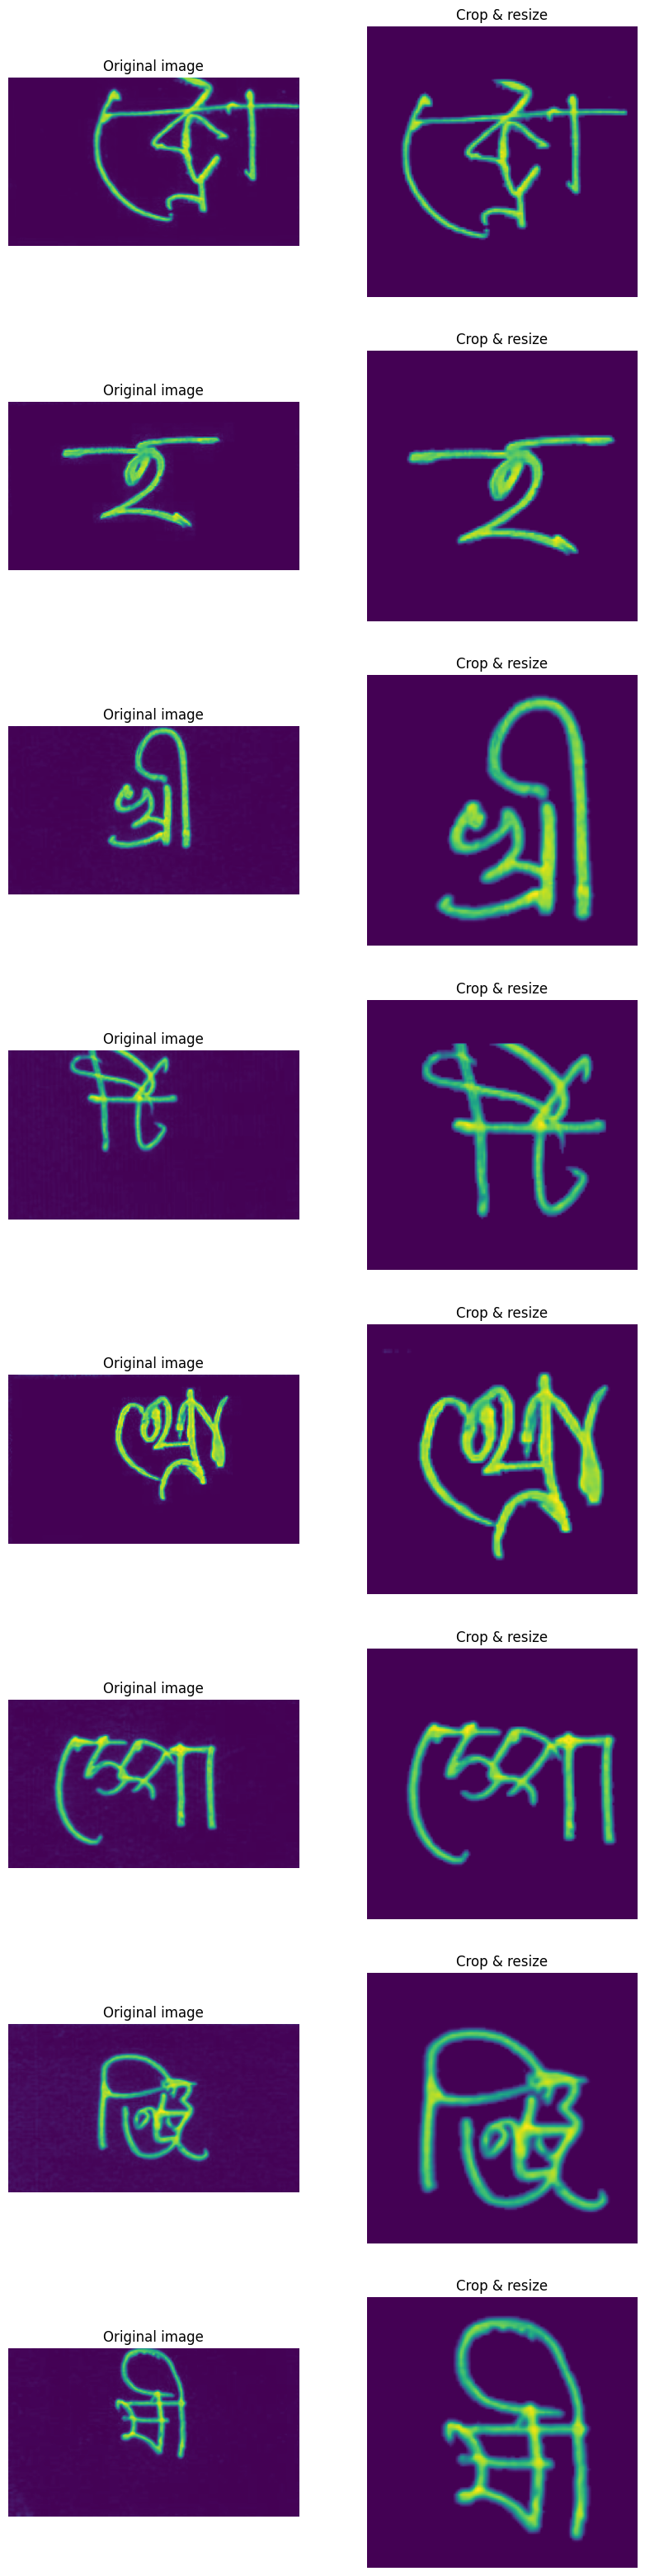

In [ ]:
df = pd.read_parquet(TRAIN[0])
n_imgs = 8
fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img0 = 255 - df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img)

    axs[idx,0].imshow(img0)
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(img)
    axs[idx,1].set_title('Crop & resize')
    axs[idx,1].axis('off')
plt.show()

In [ ]:
import cv2
from tqdm import tqdm_notebook as tqdm
import zipfile
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out:
    for fname in TRAIN:
        df = pd.read_parquet(fname)
        #the input is inverted
        data = 255 - df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
        for idx in tqdm(range(len(df))):
            name = df.iloc[idx,0]
            #normalize each image by its max val
            img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
            img = crop_resize(img)

            x_tot.append((img/255.0).mean())
            x2_tot.append(((img/255.0)**2).mean())
            img = cv2.imencode('.png',img)[1]
            img_out.writestr(name + '.png', img)

  0%|          | 0/50210 [00:00<?, ?it/s]

  0%|          | 0/50210 [00:00<?, ?it/s]

  0%|          | 0/50210 [00:00<?, ?it/s]

  0%|          | 0/50210 [00:00<?, ?it/s]

In [ ]:
del df

# Get Prep Data

In [ ]:
! cp /content/drive/MyDrive/DL-data/train.zip /content/

In [ ]:
! mkdir zipdata


In [ ]:
! unzip train.zip -d zipdata

Streaming output truncated to the last 5000 lines.
 extracting: zipdata/Train_195840.png  
 extracting: zipdata/Train_195841.png  
 extracting: zipdata/Train_195842.png  
 extracting: zipdata/Train_195843.png  
 extracting: zipdata/Train_195844.png  
 extracting: zipdata/Train_195845.png  
 extracting: zipdata/Train_195846.png  
 extracting: zipdata/Train_195847.png  
 extracting: zipdata/Train_195848.png  
 extracting: zipdata/Train_195849.png  
 extracting: zipdata/Train_195850.png  
 extracting: zipdata/Train_195851.png  
 extracting: zipdata/Train_195852.png  
 extracting: zipdata/Train_195853.png  
 extracting: zipdata/Train_195854.png  
 extracting: zipdata/Train_195855.png  
 extracting: zipdata/Train_195856.png  
 extracting: zipdata/Train_195857.png  
 extracting: zipdata/Train_195858.png  
 extracting: zipdata/Train_195859.png  
 extracting: zipdata/Train_195860.png  
 extracting: zipdata/Train_195861.png  
 extracting: zipdata/Train_195862.png  
 extracting: zipdata/Train_19

In [ ]:
import os
imgList = os.listdir('zipdata')

(128, 128, 3)
(128, 128)


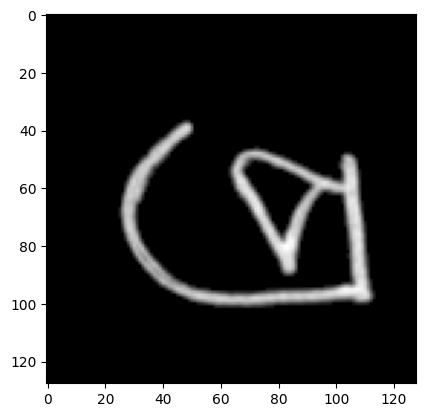

In [ ]:
index = 5
img = cv2.imread('zipdata/' + imgList[index])
print(img.shape)
# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
plt.imshow(gray, cmap='gray')

In [ ]:
import torchvision.transforms as transforms


def get_transform(grayscale=True, convert=True):

    transform_list = []
    if grayscale:
        transform_list.append(transforms.Grayscale(1))

    if convert:
        transform_list += [transforms.ToTensor()]
        if grayscale:
            transform_list += [transforms.Normalize((0.5,), (0.5,))]
        else:
            transform_list += [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

    return transforms.Compose(transform_list)


# Train

In [ ]:
# encoder = FeatureEnocoder()
encoder = getDiscSubNet()

decoder = FCNDecoder(res_norm = 'in')


initialize network with N02


<ipython-input-9-ae4e739ac870>:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netD.load_state_dict(torch.load('/content/drive/MyDrive/DL-data/discriminatorFin.pth'))


In [ ]:
# load decoder.pth and encoder.pth
decoder.load_state_dict(torch.load('/content/drive/MyDrive/DL-data/decoder.pth', 'cpu'))
# encoder.load_state_dict(torch.load('/content/drive/MyDrive/DL-data/encoder.pth'))

<ipython-input-12-0a8bf997c7d9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load('/content/drive/MyDrive/DL-data/decoder.pth', 'cpu'))


<All keys matched successfully>

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
# shuffle the imgList
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder.to(device)
decoder.to(device)

np.random.shuffle(imgList)

losses = []

batch_size = 32
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)
criterion = nn.MSELoss()

step = 0
saveAfter = 0

for i in range(0, len(imgList), batch_size):
    step += 1
    batch = imgList[i:i+batch_size]
    batch_imgs = []
    for img_name in batch:
        img = cv2.imread('zipdata/' + img_name)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = gray.reshape(1, 128, 128) / 255.
        batch_imgs.append(img)

    batch_imgs = np.array(batch_imgs)
    batch_imgs = (batch_imgs - 0.5) / 0.5

    optimizer.zero_grad()

    inpt = torch.tensor(batch_imgs, dtype=torch.float32).to(device)
    output = decoder(encoder(inpt))
    loss = criterion(output, inpt)
    loss.backward()
    optimizer.step()
    lv = loss.item()

    print(f'Step: {step}, Loss: {lv}')
    losses.append(lv)
    # if saveAfter == 0:
    #   torch.save(encoder.state_dict(), f'/content/drive/MyDrive/DL-data/discriminator{i}.pth')
    #   saveAfter = 1000

    # if saveAfter > 0:
    #   saveAfter -= 1
    # break



Step: 1, Loss: 0.23900094628334045
Step: 2, Loss: 0.14601770043373108
Step: 3, Loss: 0.16598615050315857


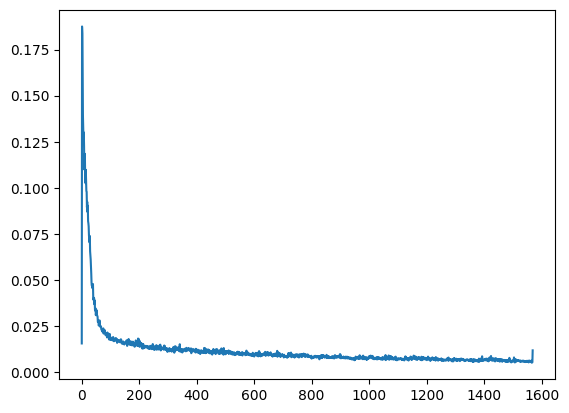

In [ ]:
plt.plot(losses)

In [ ]:
# save encoder and decoder model
torch.save(encoder.state_dict(), 'discriminator.pth')
# torch.save(decoder.state_dict(), 'decoder_2.pth')

In [ ]:
! cp discriminator.pth /content/drive/MyDrive/DL-data/
# ! cp decoder_2.pth /content/drive/MyDrive/DL-data/

In [ ]:
img = cv2.imread('zipdata/' + imgList[123])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = gray.reshape(1, 1, 128, 128) / 255.
img = (img - .5) / .5

recons = decoder(encoder(torch.tensor(img, dtype=torch.float32).to(device)))

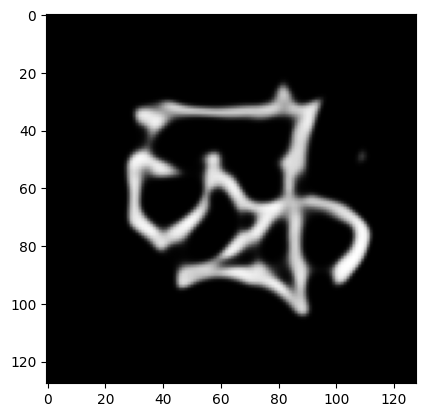

In [ ]:
plt.imshow(recons.detach().cpu().numpy().reshape(128, 128), cmap='gray')
#

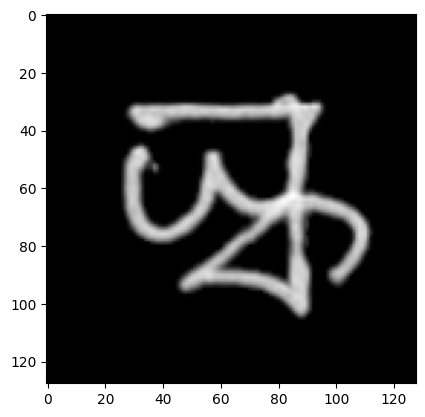

In [ ]:
plt.imshow(img.reshape(128, 128), cmap='gray')

In [ ]:
encoder.to(device)
summary(encoder, (1 ,128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 15, 128, 128]              15
            Conv2d-2           [-1, 64, 64, 64]          47,040
       BatchNorm2d-3           [-1, 64, 64, 64]             128
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [ ]:
# drop the first and last layer from encoder
new_layers = list(encoder.children())[2:-1]
new_encoder = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),*new_layers).to(device)

In [ ]:
summary(new_encoder, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [ ]:
# save the state
torch.save(new_encoder.state_dict(), 'new_encoder.pth')

In [ ]:
! cp /content/new_encoder.pth /content/drive/MyDrive/DL-data/

# Train Discriminator

In [ ]:
disc = Discriminator()
sub = getDiscSubNet()
decoder = FCNDecoder(res_norm = 'in')

initialize network with N02
initialize network with N02


In [ ]:
summary(sub, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          SNConv2d-1         [-1, 64, 128, 128]             640
              ReLU-2         [-1, 64, 128, 128]               0
              ReLU-3         [-1, 64, 128, 128]               0
              ReLU-4         [-1, 64, 128, 128]               0
              ReLU-5         [-1, 64, 128, 128]               0
          SNConv2d-6         [-1, 64, 128, 128]          36,928
         AvgPool2d-7           [-1, 64, 64, 64]               0
         AvgPool2d-8            [-1, 1, 64, 64]               0
          SNConv2d-9           [-1, 64, 64, 64]             128
           DBlock-10           [-1, 64, 64, 64]               0
         SNConv2d-11          [-1, 512, 64, 64]         295,424
             ReLU-12          [-1, 512, 64, 64]               0
             ReLU-13          [-1, 512, 64, 64]               0
             ReLU-14          [-1, 512,

In [ ]:
summary(decoder, (512, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 512, 18, 18]               0
            Conv2d-2          [-1, 512, 16, 16]       2,359,808
    InstanceNorm2d-3          [-1, 512, 16, 16]               0
              ReLU-4          [-1, 512, 16, 16]               0
       Conv2dBlock-5          [-1, 512, 16, 16]               0
   ReflectionPad2d-6          [-1, 512, 18, 18]               0
            Conv2d-7          [-1, 512, 16, 16]       2,359,808
    InstanceNorm2d-8          [-1, 512, 16, 16]               0
       Conv2dBlock-9          [-1, 512, 16, 16]               0
         ResBlock-10          [-1, 512, 16, 16]               0
  ReflectionPad2d-11          [-1, 512, 18, 18]               0
           Conv2d-12          [-1, 512, 16, 16]       2,359,808
   InstanceNorm2d-13          [-1, 512, 16, 16]               0
             ReLU-14          [-1, 512,

In [ ]:
CONJUNCTS = [
    "ক্ক", "ক্ট", "ক্ত", "ক্ত্র", "ক্ব", "ক্ম", "ক্য", "ক্র", "ক্ল", "ক্ষ", "ক্ষ্ণ", "ক্ষ্ব", "ক্ষ্ম", "ক্ষ্য", "ক্স", "র্ক", "র্ক্য", "খ্য", "খ্র", "র্খ",
    "গ্ন", "গ্ধ", "গ্ধ্য", "গ্ধ্র", "গ্ন", "গ্ন্য", "গ্ব", "গ্ম", "গ্য", "গ্র", "গ্র্য", "গ্ল", "র্গ", "র্গ্য", "র্গ্র", "ঘ্ন", "ঘ্য", "ঘ্র", "র্ঘ্য", "র্ঘ",
    "ঙ্ক", "ঙ্ক্য", "ঙ্ক্ষ", "ঙ্খ", "ঙ্খ্য", "ঙ্গ", "ঙ্গ্য", "ঙ্ঘ", "ঙ্ঘ্য", "ঙ্ঘ্র", "ঙ্ম", "র্ঙ্গ", "চ্চ", "চ্ছ", "চ্ছ্ব", "চ্ছ্র", "জ্ঞ", "জ্ঞ", "চ্ব",
    "চ্য", "র্চ্য", "র্চ", "র্ছ", "জ্জ", "জ্জ্ব", "জ্ঝ", "জ্ঞ", "জ্ব", "জ্য", "জ্র", "র্জ্য", "র্জ্জ", "র্জ্ঞ", "র্জ", "র্ঝ", "ঞ্চ", "ঞ্ছ", "ঞ্জ", "ঞ্ঝ",
    "ট্ট", "ট্ব", "ট্ম", "ট্য", "ট্র", "র্ট", "ড্ড", "ড্ব", "ড্ম", "ড্য", "ড্র", "র্ড", "ঢ্য", "ঢ্র", "র্ঢ্য", "ণ্ট", "ণ্ঠ", "ণ্ঠ্য", "ণ্ড", "ণ্ড্য", "ণ্ড্র",
    "ণ্ঢ", "ণ্ণ", "ণ্ব", "ণ্ম", "ণ্য", "র্ণ্য", "র্ণ", "ত্ত", "ত্ত্ব", "ত্ত্য", "ত্থ", "ত্ন", "ত্ব", "ত্ম", "ত্ম্য", "ত্য", "ত্র", "ত্র্য", "র্ত্য", "র্ত",
    "র্ত্ম", "র্ত্র", "থ্ব", "থ্য", "থ্র", "র্থ্য", "র্থ", "দ্গ", "দ্ঘ", "দ্দ", "দ্দ্ব", "দ্ধ", "দ্ব", "দ্ভ", "দ্ভ্র", "দ্ম", "দ্য", "দ্র", "দ্র্য", "র্দ", "র্দ্ব",
    "র্দ্র", "ধ্ন", "ধ্ব", "ধ্ম", "ধ্য", "ধ্র", "র্ধ", "র্ধ্ব", "ন্ট", "ন্ট্র", "ণ্ঠ", "ণ্ড", "ণ্ড্র", "ন্ত", "ন্ত্ব", "ন্ত্য", "ন্ত্র", "ন্ত্র্য", "ন্থ", "ন্থ্র",
    "ন্দ", "ন্দ্য", "ন্দ্ব", "ন্দ্র", "ন্ধ", "ন্ধ্য", "ন্ধ্র", "ন্ন", "ন্ব", "ন্ম", "ন্য", "র্ন", "প্ট", "প্ত", "প্ন", "প্প", "প্য", "প্র", "প্র্য", "প্ল",
    "প্স", "র্প", "ফ্র", "ফ্ল", "র্ফ", "ব্জ", "ব্দ", "ব্ধ", "ব্ব", "ব্য", "ব্র", "ব্ল", "র্ব্য", "র্ব", "ভ্ব", "ভ্য", "ভ্র", "ভ্ল", "র্ভ", "ম্ন", "ম্প",
    "ম্প্র", "ম্ফ", "ম্ব", "ম্ব্র", "ম্ভ", "ম্ভ্র", "ম্ম", "ম্য", "ম্র", "ম্ল", "র্ম্য", "র্ম", "য্য", "র্য", "ল্ক", "ল্ক্য", "ল্গ", "ল্ট", "ল্ড", "ল্প",
    "ল্ফ", "ল্ব", "ল্ভ", "ল্ম", "ল্য", "ল্ল", "র্ল", "শ্চ", "শ্ছ", "শ্ন", "শ্ব", "শ্ম", "শ্য", "শ্র", "শ্ল", "র্শ্য", "র্শ", "র্শ্ব", "ষ্ক", "ষ্ক্ব", "ষ্ক্র",
    "ষ্ট", "ষ্ট্য", "ষ্ট্র", "ষ্ঠ", "ষ্ঠ্য", "ষ্ণ", "ষ্ণ্ব", "ষ্প", "ষ্প্র", "ষ্ফ", "ষ্ব", "ষ্ম", "ষ্য", "র্ষ্য", "র্ষ", "র্ষ্ট", "র্ষ্ণ", "র্ষ্ণ্য", "স্ক",
    "স্ক্র", "স্খ", "স্ট", "স্ট্র", "স্ত", "স্ত্ব", "স্ত্য", "স্ত্র", "স্থ", "স্থ্য", "স্ন", "স্ন্য", "স্প", "স্প্র", "স্প্ল", "স্ফ", "স্ব", "স্ম",
    "স্য", "স্র", "স্ল", "স্ক্ল", "র্স", "হ্ণ", "হ্ন", "হ্ব", "হ্ম", "হ্য", "হ্র", "হ্ল", "র্হ্য", "র্হ", "ড়্গ", "র্ত"
]
print(len(CONJUNCTS))

296
